In [11]:
from pathlib import Path
from importlib import reload
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import matplotlib.pyplot as plt
import numpy as np
import random

In [12]:
OUTPUT_PATH = "./data/Dane-Polcom-Processed/"

In [13]:

from prototyping.src import extract

reload(extract)

from prototyping.src.extract import (
    extract_resource_consumption_from_dataset_2022_M,
    extract_resource_consumption_from_dataset_2022_Y,
    get_metadata_about_resource_consumption
)

In [14]:
def concat_dataframes_horizontally(dataframes: list[pd.DataFrame]) -> pd.DataFrame:
    processed_dfs = []

    for idx, df in enumerate(dataframes):
        # Resolve duplicate indices by aggregating
        if not df.index.is_unique:
            df = df.groupby(df.index).mean()

        # Ensure unique column names by adding a suffix if needed
        df = df.add_suffix(f"_{idx + 1}")
        processed_dfs.append(df)

    # Concatenate dataframes with unique columns
    result = pd.concat(processed_dfs, axis=1)

    # Reset column names if they were unique originally
    result.columns = [col.split("_")[0] if list(result.columns).count(col.split("_")[0]) == 1 else col
                      for col in result.columns]

    return result

In [15]:
def extract_consumption_data_from_dataset_2022_Y(output_path, type) -> None:
    vmware_to_local = {
        "DM": "VM01",
        "PM": "VM02",
        "R02": "VM03",
        "R03": "VM04",
        "R04": "VM05",
        "S": "VM06",
        "V02": "VM07",
        "V03": "VM08",
    }

    local_to_vmware = {v: k for k, v in vmware_to_local.items()}

    VIRTUAL_MACHINES: list[str] = [
        "VM01", "VM02", "VM03", "VM04", "VM05", "VM06", "VM07", "VM08"
    ]
    DATASET_2022_Y_PATH = "data/raw/Dane-Polcom/2022/AGH2022/"

    for virtual_machine_id in VIRTUAL_MACHINES:
        vmware_server_id: str = local_to_vmware[virtual_machine_id]

        print(DATASET_2022_Y_PATH + vmware_server_id)

        metadata = get_metadata_about_resource_consumption(
            DATASET_2022_Y_PATH + vmware_server_id
        )

        print(metadata)
        extract_resource_consumption_from_dataset_2022_func = extract_resource_consumption_from_dataset_2022_Y if type == 'Y' else extract_resource_consumption_from_dataset_2022_M
        
        dfs: list[pd.DataFrame] = extract_resource_consumption_from_dataset_2022_func(vmware_server_id, metadata)

        df_merged: pd.DataFrame = concat_dataframes_horizontally(dfs)
        df_merged = df_merged.fillna(0)

        destination: str = f"{output_path}{type}/{vmware_server_id}.parquet"
        print(f"Saving {vmware_server_id} combined consumption data to {destination}")
        df_merged.to_parquet(destination)

extract_consumption_data_from_dataset_2022_Y(OUTPUT_PATH + "2022/", 'Y')
extract_consumption_data_from_dataset_2022_Y(OUTPUT_PATH + "2022/", 'M')

./data/Dane-Polcom/2022/AGH2022/DM
paths: [PosixPath('data/Dane-Polcom/2022/AGH2022/DM/DM_cpu_1M.csv'), PosixPath('data/Dane-Polcom/2022/AGH2022/DM/DM_cpu_1Y.csv'), PosixPath('data/Dane-Polcom/2022/AGH2022/DM/DM_memory_1M.csv'), PosixPath('data/Dane-Polcom/2022/AGH2022/DM/DM_memory_1Y.csv'), PosixPath('data/Dane-Polcom/2022/AGH2022/DM/DM_node1_disk_1M.csv'), PosixPath('data/Dane-Polcom/2022/AGH2022/DM/DM_node1_disk_1Y.csv'), PosixPath('data/Dane-Polcom/2022/AGH2022/DM/DM_node1_network_1M.csv'), PosixPath('data/Dane-Polcom/2022/AGH2022/DM/DM_node1_network_1Y.csv')]
{'cpu': 'data/Dane-Polcom/2022/AGH2022/DM/DM_cpu_1M.csv', 'memory': 'data/Dane-Polcom/2022/AGH2022/DM/DM_memory_1M.csv', 'disk': [{'1': 'data/Dane-Polcom/2022/AGH2022/DM/DM_node1_disk_1M.csv'}, {'1': 'data/Dane-Polcom/2022/AGH2022/DM/DM_node1_disk_1Y.csv'}], 'network': [{'1': 'data/Dane-Polcom/2022/AGH2022/DM/DM_node1_network_1M.csv'}, {'1': 'data/Dane-Polcom/2022/AGH2022/DM/DM_node1_network_1Y.csv'}]}
Saving DM combined cons

In [16]:
PROCESSED_DATA_M = "./data/Dane-Polcom-Processed/2022/M/"
PROCESSED_DATA_Y = "./data/Dane-Polcom-Processed/2022/Y/"

dfs_M = [pd.read_parquet(file) for file in Path(PROCESSED_DATA_M).glob("*.parquet")]
dfs_Y = [pd.read_parquet(file) for file in Path(PROCESSED_DATA_Y).glob("*.parquet")]

df_combined_M = pd.concat(dfs_M)
df_combined_Y = pd.concat(dfs_Y)

In [17]:
df_combined_M

,CPU_USAGE_MHZ_1,CPU_USAGE_PERCENT_1,MEMORY_USAGE_KB_2,MEMORY_USAGE_PERCENT_2,NODE_1_DISK_IO_RATE_KBPS_3,NODE_1_DISK_IO_RATE_KBPS_4,NODE_2_DISK_IO_RATE_KBPS_5,NODE_2_DISK_IO_RATE_KBPS_6,NODE_3_DISK_IO_RATE_KBPS_7,NODE_3_DISK_IO_RATE_KBPS_8,...,NODE_3_NETWORK_T_RATE_KBPS_15,NODE_3_NETWORK_TR_KBPS_16,NODE_3_NETWORK_R_RATE_KBPS_16,NODE_3_NETWORK_T_RATE_KBPS_16,NODE_4_NETWORK_TR_KBPS_17,NODE_4_NETWORK_R_RATE_KBPS_17,NODE_4_NETWORK_T_RATE_KBPS_17,NODE_4_NETWORK_TR_KBPS_18,NODE_4_NETWORK_R_RATE_KBPS_18,NODE_4_NETWORK_T_RATE_KBPS_18
DATE,,,,,,,,,,,,,,,,,,,,,
2022-03-13 14:00:00,60035.0,33.0,2.526256e+09,52.0,31660.0,0.0,4263.0,0.0,3435.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-13 16:00:00,59883.0,33.0,2.526454e+09,52.0,24207.0,0.0,3675.0,0.0,5033.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-13 18:00:00,57655.0,32.0,2.526509e+09,52.0,45169.0,0.0,2964.0,0.0,6973.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-13 20:00:00,50277.0,27.0,2.526517e+09,52.0,31046.0,0.0,2938.0,0.0,6880.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-13 22:00:00,53088.0,29.0,2.526513e+09,52.0,203816.0,0.0,11969.0,0.0,4394.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-10 00:00:00,0.0,0.0,0.000000e+00,0.0,0.0,16298.0,0.0,7475.0,0.0,6128.0,...,0.0,32386.0,14231.0,18155.0,0.0,0.0,0.0,2788.0,207.0,2580.0
2022-03-11 00:00:00,0.0,0.0,0.000000e+00,0.0,0.0,25679.0,0.0,8274.0,0.0,5768.0,...,0.0,26718.0,11588.0,15130.0,0.0,0.0,0.0,10056.0,3373.0,6683.0
2022-03-12 00:00:00,0.0,0.0,0.000000e+00,0.0,0.0,14824.0,0.0,4146.0,0.0,13498.0,...,0.0,12285.0,7089.0,5195.0,0.0,0.0,0.0,5642.0,521.0,5120.0


In [18]:
df_combined_Y

,CPU_USAGE_MHZ_1,CPU_USAGE_PERCENT_1,MEMORY_USAGE_KB_2,MEMORY_USAGE_PERCENT_2,NODE_1_DISK_IO_RATE_KBPS_3,NODE_1_DISK_IO_RATE_KBPS_4,NODE_2_DISK_IO_RATE_KBPS_5,NODE_2_DISK_IO_RATE_KBPS_6,NODE_3_DISK_IO_RATE_KBPS_7,NODE_3_DISK_IO_RATE_KBPS_8,...,NODE_3_NETWORK_T_RATE_KBPS_15,NODE_3_NETWORK_TR_KBPS_16,NODE_3_NETWORK_R_RATE_KBPS_16,NODE_3_NETWORK_T_RATE_KBPS_16,NODE_4_NETWORK_TR_KBPS_17,NODE_4_NETWORK_R_RATE_KBPS_17,NODE_4_NETWORK_T_RATE_KBPS_17,NODE_4_NETWORK_TR_KBPS_18,NODE_4_NETWORK_R_RATE_KBPS_18,NODE_4_NETWORK_T_RATE_KBPS_18
DATE,,,,,,,,,,,,,,,,,,,,,
2022-03-13,56187.600000,30.800000,2.526450e+09,52.000000,64028.000000,77475.0,5161.800000,13736.0,5343.000000,8841.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-14,92694.666667,50.916667,2.527748e+09,52.000000,61663.000000,49898.0,7999.333333,11214.0,15153.000000,4380.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-15,98166.166667,54.083333,2.528534e+09,52.000000,55710.333333,55473.0,8199.000000,15007.0,11235.333333,4523.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-16,104520.833333,57.666667,2.528762e+09,52.000000,57430.666667,56581.0,11589.333333,10933.0,14900.666667,5155.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-17,98186.083333,54.000000,2.513983e+09,52.083333,31195.833333,54021.0,29372.750000,15467.0,23307.666667,5648.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-09,0.000000,0.000000,0.000000e+00,0.000000,0.000000,11599.0,0.000000,9953.0,0.000000,8201.0,...,0.0,34290.0,15460.0,18829.0,0.0,0.0,0.0,5626.0,736.0,4889.0
2022-03-10,0.000000,0.000000,0.000000e+00,0.000000,0.000000,16298.0,0.000000,7475.0,0.000000,6128.0,...,0.0,32386.0,14231.0,18155.0,0.0,0.0,0.0,2788.0,207.0,2580.0
2022-03-11,0.000000,0.000000,0.000000e+00,0.000000,0.000000,25679.0,0.000000,8274.0,0.000000,5768.0,...,0.0,26718.0,11588.0,15130.0,0.0,0.0,0.0,10056.0,3373.0,6683.0


In [19]:
df_combined_M.index = pd.to_datetime(df_combined_M.index)
df_combined_Y.index = pd.to_datetime(df_combined_Y.index)

In [20]:
df_combined_M

,CPU_USAGE_MHZ_1,CPU_USAGE_PERCENT_1,MEMORY_USAGE_KB_2,MEMORY_USAGE_PERCENT_2,NODE_1_DISK_IO_RATE_KBPS_3,NODE_1_DISK_IO_RATE_KBPS_4,NODE_2_DISK_IO_RATE_KBPS_5,NODE_2_DISK_IO_RATE_KBPS_6,NODE_3_DISK_IO_RATE_KBPS_7,NODE_3_DISK_IO_RATE_KBPS_8,...,NODE_3_NETWORK_T_RATE_KBPS_15,NODE_3_NETWORK_TR_KBPS_16,NODE_3_NETWORK_R_RATE_KBPS_16,NODE_3_NETWORK_T_RATE_KBPS_16,NODE_4_NETWORK_TR_KBPS_17,NODE_4_NETWORK_R_RATE_KBPS_17,NODE_4_NETWORK_T_RATE_KBPS_17,NODE_4_NETWORK_TR_KBPS_18,NODE_4_NETWORK_R_RATE_KBPS_18,NODE_4_NETWORK_T_RATE_KBPS_18
DATE,,,,,,,,,,,,,,,,,,,,,
2022-03-13 14:00:00,60035.0,33.0,2.526256e+09,52.0,31660.0,0.0,4263.0,0.0,3435.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-13 16:00:00,59883.0,33.0,2.526454e+09,52.0,24207.0,0.0,3675.0,0.0,5033.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-13 18:00:00,57655.0,32.0,2.526509e+09,52.0,45169.0,0.0,2964.0,0.0,6973.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-13 20:00:00,50277.0,27.0,2.526517e+09,52.0,31046.0,0.0,2938.0,0.0,6880.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-13 22:00:00,53088.0,29.0,2.526513e+09,52.0,203816.0,0.0,11969.0,0.0,4394.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-10 00:00:00,0.0,0.0,0.000000e+00,0.0,0.0,16298.0,0.0,7475.0,0.0,6128.0,...,0.0,32386.0,14231.0,18155.0,0.0,0.0,0.0,2788.0,207.0,2580.0
2022-03-11 00:00:00,0.0,0.0,0.000000e+00,0.0,0.0,25679.0,0.0,8274.0,0.0,5768.0,...,0.0,26718.0,11588.0,15130.0,0.0,0.0,0.0,10056.0,3373.0,6683.0
2022-03-12 00:00:00,0.0,0.0,0.000000e+00,0.0,0.0,14824.0,0.0,4146.0,0.0,13498.0,...,0.0,12285.0,7089.0,5195.0,0.0,0.0,0.0,5642.0,521.0,5120.0


## Eksploration

In [21]:
print("Basic Statistics for Dataset M:")
print(df_combined_M.describe())

print("\nBasic Statistics for Dataset Y:")
print(df_combined_Y.describe())

Basic Statistics for Dataset M:
       CPU_USAGE_MHZ_1  CPU_USAGE_PERCENT_1  MEMORY_USAGE_KB_2  \
count      5572.000000          5572.000000       5.572000e+03   
mean      16702.055276             9.920495       4.198124e+08   
std       26883.187526            15.310675       7.528860e+08   
min           0.000000             0.000000       0.000000e+00   
25%           0.000000             0.000000       0.000000e+00   
50%           6.000000             0.000000       8.272111e+06   
75%       29183.250000            16.000000       6.904578e+08   
max      154228.000000            85.000000       2.560914e+09   

       MEMORY_USAGE_PERCENT_2  NODE_1_DISK_IO_RATE_KBPS_3  \
count             5572.000000                 5572.000000   
mean                11.444630                 4338.568557   
std                 16.736216                15941.658048   
min                  0.000000                    0.000000   
25%                  0.000000                    0.000000   
50%    

In [22]:
print("\nMissing Values in Dataset M:")
print(df_combined_M.isnull().sum())

print("\nMissing Values in Dataset Y:")
print(df_combined_Y.isnull().sum())


Missing Values in Dataset M:
CPU_USAGE_MHZ_1                     0
CPU_USAGE_PERCENT_1                 0
MEMORY_USAGE_KB_2                   0
MEMORY_USAGE_PERCENT_2              0
NODE_1_DISK_IO_RATE_KBPS_3          0
                                 ... 
NODE_4_NETWORK_R_RATE_KBPS_17    4877
NODE_4_NETWORK_T_RATE_KBPS_17    4877
NODE_4_NETWORK_TR_KBPS_18        4877
NODE_4_NETWORK_R_RATE_KBPS_18    4877
NODE_4_NETWORK_T_RATE_KBPS_18    4877
Length: 76, dtype: int64

Missing Values in Dataset Y:
CPU_USAGE_MHZ_1                     0
CPU_USAGE_PERCENT_1                 0
MEMORY_USAGE_KB_2                   0
MEMORY_USAGE_PERCENT_2              0
NODE_1_DISK_IO_RATE_KBPS_3          0
                                 ... 
NODE_4_NETWORK_R_RATE_KBPS_17    2556
NODE_4_NETWORK_T_RATE_KBPS_17    2556
NODE_4_NETWORK_TR_KBPS_18        2556
NODE_4_NETWORK_R_RATE_KBPS_18    2556
NODE_4_NETWORK_T_RATE_KBPS_18    2556
Length: 76, dtype: int64


In [23]:
print(f"\nDate Range for Dataset M: {df_combined_M.index.min()} to {df_combined_M.index.max()}")
print(f"\nDate Range for Dataset Y: {df_combined_Y.index.min()} to {df_combined_Y.index.max()}")


Date Range for Dataset M: 2021-04-13 00:00:00 to 2022-04-13 12:00:00

Date Range for Dataset Y: 2021-04-13 00:00:00 to 2022-04-13 00:00:00


In [24]:
print(f"\nDuplicate Index Values in M: {df_combined_M.index.duplicated().sum()}")
print(f"Duplicate Index Values in Y: {df_combined_Y.index.duplicated().sum()}")


Duplicate Index Values in M: 4864
Duplicate Index Values in Y: 2555


In [25]:
df_combined_M = df_combined_M.dropna(axis=1, how='any')

In [26]:
print(df_combined_M.isna().sum())

CPU_USAGE_MHZ_1               0
CPU_USAGE_PERCENT_1           0
MEMORY_USAGE_KB_2             0
MEMORY_USAGE_PERCENT_2        0
NODE_1_DISK_IO_RATE_KBPS_3    0
NODE_1_DISK_IO_RATE_KBPS_4    0
dtype: int64


Remaining columns: Index(['CPU_USAGE_MHZ_1', 'CPU_USAGE_PERCENT_1', 'MEMORY_USAGE_KB_2',
       'MEMORY_USAGE_PERCENT_2', 'NODE_1_DISK_IO_RATE_KBPS_3',
       'NODE_1_DISK_IO_RATE_KBPS_4'],
      dtype='object')


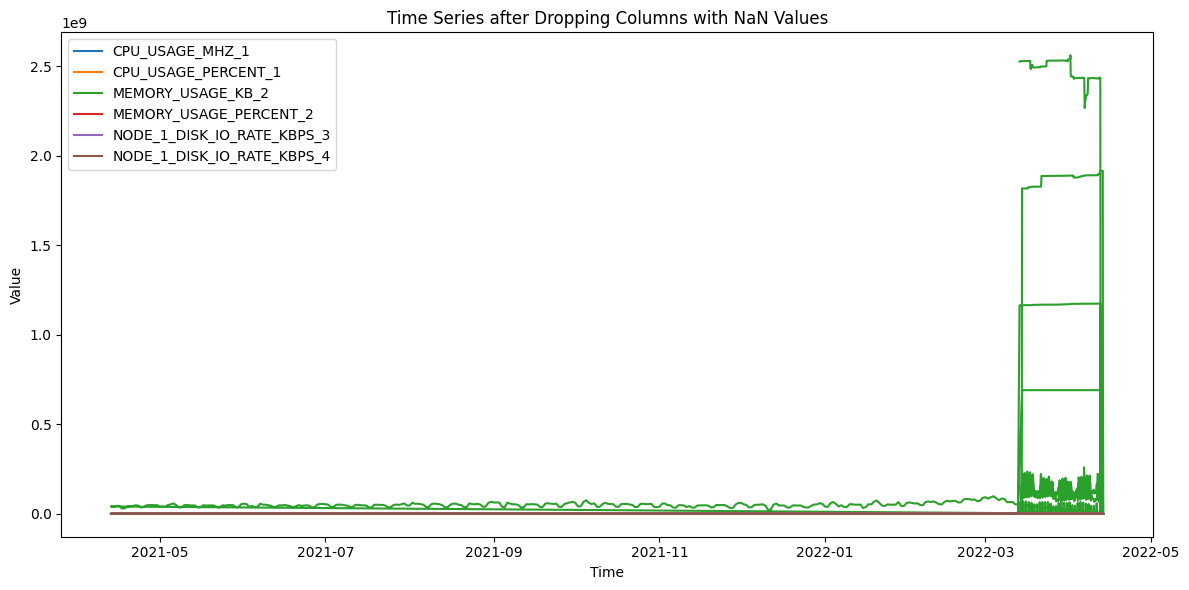

In [27]:
print("Remaining columns:", df_combined_M.columns)

plt.figure(figsize=(12, 6))
for col in df_combined_M.columns:
    plt.plot(df_combined_M.index, df_combined_M[col], label=col)

plt.title("Time Series after Dropping Columns with NaN Values")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
cut_off_date = '2022-03-25'
df_cleaned = df_combined_M[df_combined_M.index < cut_off_date]

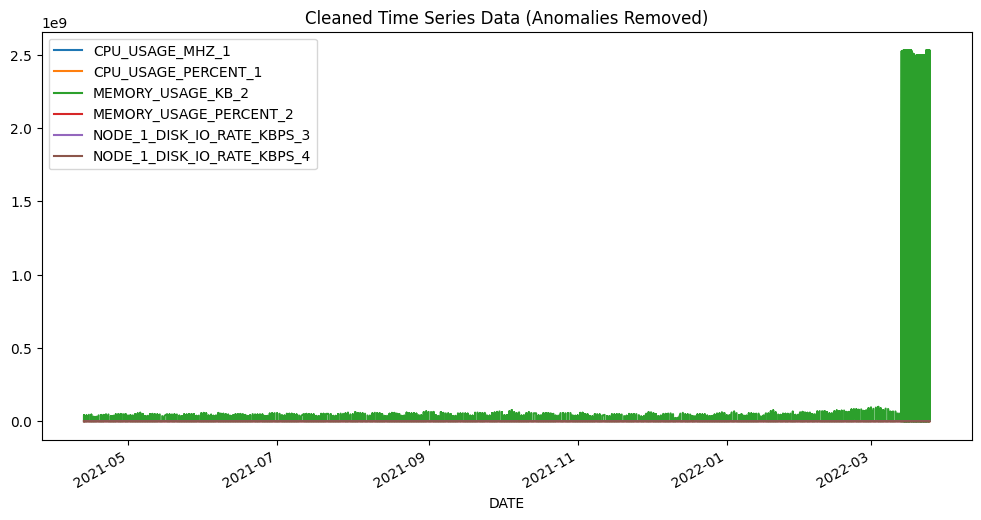

In [29]:
df_cleaned.plot(figsize=(12, 6))
plt.title("Cleaned Time Series Data (Anomalies Removed)")
plt.show()

In [30]:
df_cleaned

,CPU_USAGE_MHZ_1,CPU_USAGE_PERCENT_1,MEMORY_USAGE_KB_2,MEMORY_USAGE_PERCENT_2,NODE_1_DISK_IO_RATE_KBPS_3,NODE_1_DISK_IO_RATE_KBPS_4
DATE,,,,,,
2022-03-13 14:00:00,60035.0,33.0,2.526256e+09,52.0,31660.0,0.0
2022-03-13 16:00:00,59883.0,33.0,2.526454e+09,52.0,24207.0,0.0
2022-03-13 18:00:00,57655.0,32.0,2.526509e+09,52.0,45169.0,0.0
2022-03-13 20:00:00,50277.0,27.0,2.526517e+09,52.0,31046.0,0.0
2022-03-13 22:00:00,53088.0,29.0,2.526513e+09,52.0,203816.0,0.0
...,...,...,...,...,...,...
2022-03-10 00:00:00,0.0,0.0,0.000000e+00,0.0,0.0,16298.0
2022-03-11 00:00:00,0.0,0.0,0.000000e+00,0.0,0.0,25679.0
2022-03-12 00:00:00,0.0,0.0,0.000000e+00,0.0,0.0,14824.0


NameError: name 'df_combined_M' is not defined

In [31]:
df_combined_M = df_cleaned

In [32]:
data = df_combined_M.copy()
data['hour_of_day'] = data.index.hour
data['day_of_month'] = data.index.day
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.values)
data_tensor = torch.tensor(data_scaled, dtype=torch.float32)

In [33]:
sequence_length = 12 # 24hrs
forecast_horizon = 12 # 24hrs
def create_sequences(data, seq_length, forecast_horizon):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        seq = data[i:i + seq_length]
        label = data[i + seq_length:i + seq_length + forecast_horizon]
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.stack(labels)

sequences, labels = create_sequences(data_tensor, sequence_length, forecast_horizon)

In [34]:
# CNN-LSTM Model Definition
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, output_size):
        super(CNN_LSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.lstm = nn.LSTM(input_size=32, hidden_size=lstm_hidden_size, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(lstm_hidden_size, output_size)

    def forward(self, x):
        x = self.cnn(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        # Reshape to match the label shape: [batch_size, forecast_horizon, features]
        return output.view(-1, forecast_horizon, data_tensor.shape[1])

In [35]:
# Model initialization
input_size = data_tensor.shape[1]
lstm_hidden_size = 64
output_size = forecast_horizon * data_tensor.shape[1]
model = CNN_LSTM(input_size, lstm_hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [36]:
# Backtesting for CNN-LSTM Model
train_size = int(0.5 * len(sequences))
train_sequences, test_sequences = sequences[:train_size], sequences[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

In [37]:
model.train()
for epoch in range(5):
    optimizer.zero_grad()
    predictions = model(train_sequences)
    loss = criterion(predictions, train_labels)
    loss.backward()
    optimizer.step()

In [38]:
model.eval()
with torch.no_grad():
    predictions = model(train_sequences)
    mse = criterion(predictions, train_labels).item()
    rmse = np.sqrt(mse)
    mae = torch.mean(torch.abs(predictions - train_labels)).item()
    print(f"Initial Training - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    
# Save initial model state for comparison
initial_model_state = model.state_dict().copy()

Initial Training - MSE: 0.0837, RMSE: 0.2893, MAE: 0.1737


In [ ]:
backtesting_losses = []
for i in range(len(test_sequences)):
    model.train()
    optimizer.zero_grad()
    predictions = model(train_sequences)
    loss = criterion(predictions, train_labels)
    loss.backward()
    optimizer.step()
    backtesting_losses.append(loss.item())

    # Gradually expand the training set
    train_sequences = torch.cat((train_sequences, test_sequences[i].unsqueeze(0)))
    train_labels = torch.cat((train_labels, test_labels[i].unsqueeze(0)))
    print(f"Backtesting Step {i+1}/{len(test_sequences)}, Loss: {loss.item()}")

Backtesting Step 1/1850, Loss: 0.0836692824959755
Backtesting Step 2/1850, Loss: 0.08160144090652466
Backtesting Step 3/1850, Loss: 0.07951430231332779
Backtesting Step 4/1850, Loss: 0.07738237828016281
Backtesting Step 5/1850, Loss: 0.07518947124481201
Backtesting Step 6/1850, Loss: 0.07291918247938156
Backtesting Step 7/1850, Loss: 0.07056097686290741
Backtesting Step 8/1850, Loss: 0.06809981167316437
Backtesting Step 9/1850, Loss: 0.06552816927433014
Backtesting Step 10/1850, Loss: 0.06284560263156891
Backtesting Step 11/1850, Loss: 0.06006021797657013
Backtesting Step 12/1850, Loss: 0.057191673666238785
Backtesting Step 13/1850, Loss: 0.05427473038434982
Backtesting Step 14/1850, Loss: 0.051364779472351074
Backtesting Step 15/1850, Loss: 0.048547446727752686
Backtesting Step 16/1850, Loss: 0.04592073708772659
Backtesting Step 17/1850, Loss: 0.0435861200094223
Backtesting Step 18/1850, Loss: 0.04161679744720459
Backtesting Step 19/1850, Loss: 0.04000940918922424
Backtesting Step 20/

In [29]:
# Save the backtested model
backtested_model_state = model.state_dict().copy()
torch.save(backtested_model_state, "cnn_lstm_model_backtesting.pth")

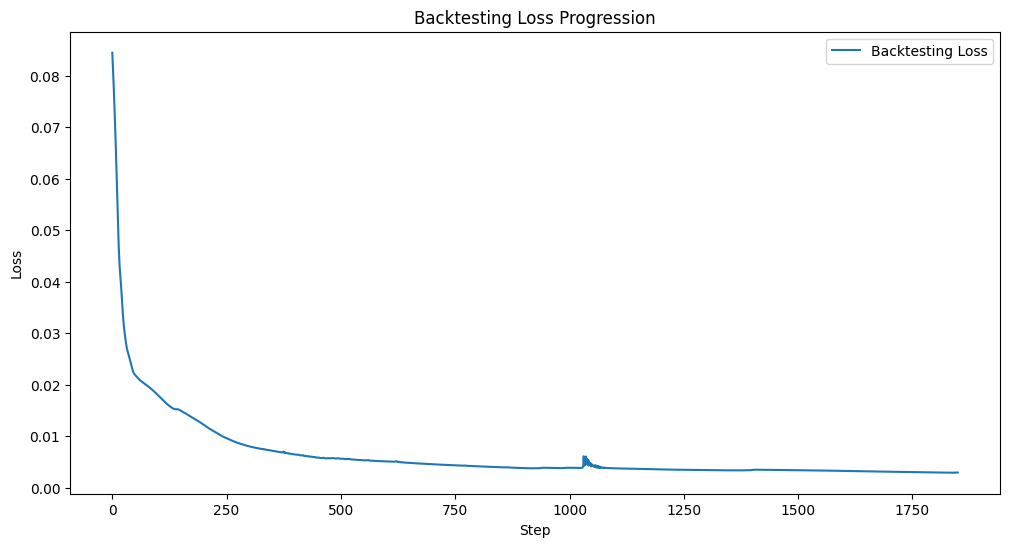

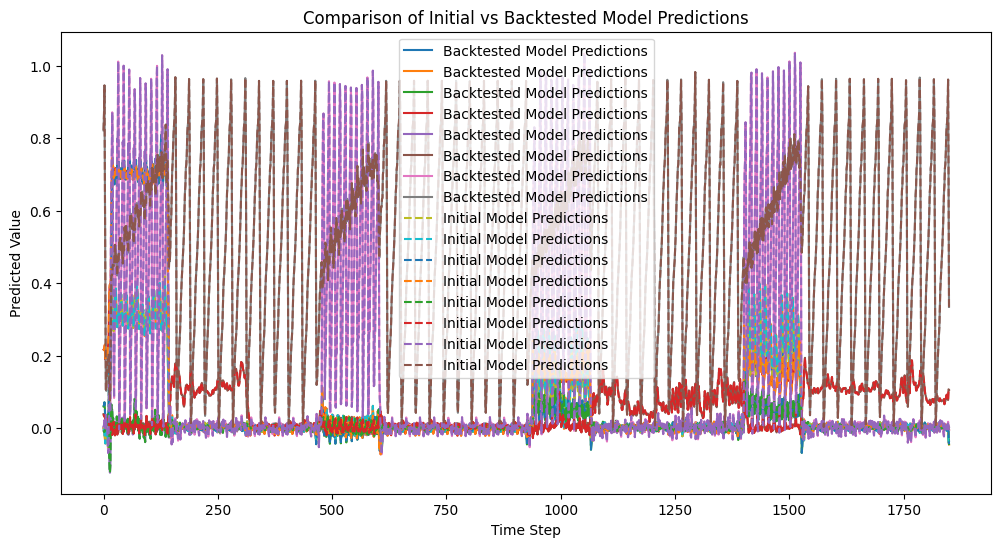

In [30]:
# Visualize backtesting loss
plt.figure(figsize=(12, 6))
plt.plot(backtesting_losses, label='Backtesting Loss')
plt.title('Backtesting Loss Progression')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Compare final test predictions of both models
model.load_state_dict(initial_model_state)
initial_predictions = model(test_sequences).detach().numpy()
model.load_state_dict(backtested_model_state)
final_predictions = model(test_sequences).detach().numpy()

# Plot comparison of initial vs final predictions
plt.figure(figsize=(12, 6))
plt.plot(final_predictions[:, 0], label='Backtested Model Predictions')
plt.plot(initial_predictions[:, 0], label='Initial Model Predictions', linestyle='--')
plt.title('Comparison of Initial vs Backtested Model Predictions')
plt.xlabel('Time Step')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()

In [31]:
sequence_length = 24
forecast_horizon = 24

In [ ]:
# Load and prepare data with time-based features
data = df_combined_M.copy()
data['hour_of_day'] = data.index.hour
data['day_of_month'] = data.index.day
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.values)
data_tensor = torch.tensor(data_scaled, dtype=torch.float32)

# Prepare sequence data for LSTM with last month's data to predict next month
def create_sequences(data, seq_length, forecast_horizon):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        seq = data[i:i + seq_length]
        label = data[i + seq_length:i + seq_length + forecast_horizon]
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.stack(labels)

# CNN-LSTM Model Definition (Unidirectional)
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, output_size):
        super(CNN_LSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.lstm = nn.LSTM(input_size=32, hidden_size=lstm_hidden_size, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(lstm_hidden_size, output_size)

    def forward(self, x):
        x = self.cnn(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output  # Returning without reshaping

# Particle Swarm Optimization with Genetic Algorithm
class DPSO_GA:
    def __init__(self, num_particles, sequence_range, forecast_range, lstm_hidden_range, lr_range, max_iter):
        self.num_particles = num_particles
        self.sequence_range = sequence_range
        self.forecast_range = forecast_range
        self.lstm_hidden_range = lstm_hidden_range
        self.lr_range = lr_range
        self.max_iter = max_iter
        self.particles = self.initialize_particles()
        self.global_best = None
        self.global_best_score = float('inf')

    def initialize_particles(self):
        particles = []
        for _ in range(self.num_particles):
            particle = {
                'sequence_length': random.randint(*self.sequence_range),
                'forecast_horizon': random.randint(*self.forecast_range),
                'lstm_hidden_size': random.randint(*self.lstm_hidden_range),
                'lr': 10 ** random.uniform(self.lr_range[0], self.lr_range[1]),
                'velocity': np.random.rand(4),
                'best_position': None,
                'best_score': float('inf')
            }
            particles.append(particle)
        return particles

    def fitness(self, particle):
        sequence_length = particle['sequence_length']
        forecast_horizon = particle['forecast_horizon']
        lstm_hidden_size = particle['lstm_hidden_size']
        lr = particle['lr']

        # Prepare data for the current particle
        sequences, labels = create_sequences(data_tensor, sequence_length, forecast_horizon)
        train_size = int(0.7 * len(sequences))
        train_sequences, test_sequences = sequences[:train_size], sequences[train_size:]
        train_labels, test_labels = labels[:train_size], labels[train_size:]

        # Train a model using the current particle's parameters
        model = CNN_LSTM(input_size=data_tensor.shape[1], lstm_hidden_size=lstm_hidden_size,
                         output_size=forecast_horizon * data_tensor.shape[1])
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        model.train()
        for epoch in range(3):
            optimizer.zero_grad()
            predictions = model(train_sequences)
            predictions = predictions.view(train_labels.shape)  # Fixing shape for loss calculation
            loss = criterion(predictions, train_labels)
            loss.backward()
            optimizer.step()

        # Calculate final validation loss
        model.eval()
        with torch.no_grad():
            predictions = model(test_sequences)
            predictions = predictions.view(test_labels.shape)  # Fixing shape again for evaluation
            loss = criterion(predictions, test_labels).item()

        return loss

    def optimize(self):
        for iteration in range(self.max_iter):
            for particle in self.particles:
                score = self.fitness(particle)
                if score < particle['best_score']:
                    particle['best_score'] = score
                    particle['best_position'] = particle.copy()
                if score < self.global_best_score:
                    self.global_best_score = score
                    self.global_best = particle.copy()

            # Update particles using PSO
            for particle in self.particles:
                inertia = 0.5
                cognitive_weight = 1.5
                social_weight = 1.5
                for idx, key in enumerate(['sequence_length', 'forecast_horizon', 'lstm_hidden_size', 'lr']):
                    velocity = (inertia * particle['velocity'][idx]
                                + cognitive_weight * random.random() * (particle['best_position'][key] - particle[key])
                                + social_weight * random.random() * (self.global_best[key] - particle[key]))
                    particle['velocity'][idx] = velocity
                    particle[key] = int(particle[key] + velocity) if key != 'lr' else particle[key] + velocity

            print(f"Iteration {iteration+1}/{self.max_iter}, Best Loss: {self.global_best_score:.4f}")

        return self.global_best

dpso_ga = DPSO_GA(num_particles=10, sequence_range=(100, 720), forecast_range=(100, 720), lstm_hidden_range=(32, 128), lr_range=(-4, -1), max_iter=10)
best_hyperparameters = dpso_ga.optimize()
print("Best Hyperparameters:", best_hyperparameters)